In [6]:
import numpy as np
from sympy import *
from sympy.solvers import solve
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def create_A_Sigma(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

### 2 nodes
$\text{rank}(A) = 4 = p^2$

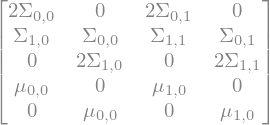

In [7]:
p = 2
cov = MatrixSymbol("Sigma", p, p).as_mutable()
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [8]:
A.rank()

### 3 nodes
$\text{rank}(A) = 8 = p^2$ - 1

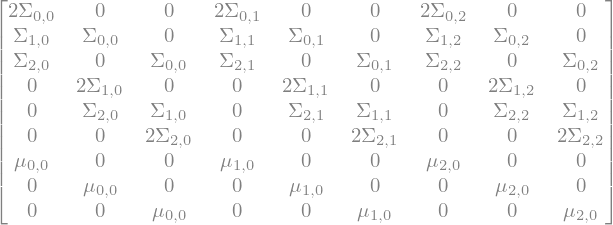

In [9]:
p = 3
cov = MatrixSymbol("Sigma", p, p).as_mutable()
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [10]:
A.rank()

### 4 nodes
$\text{rank}(A) = 4 = p^2$

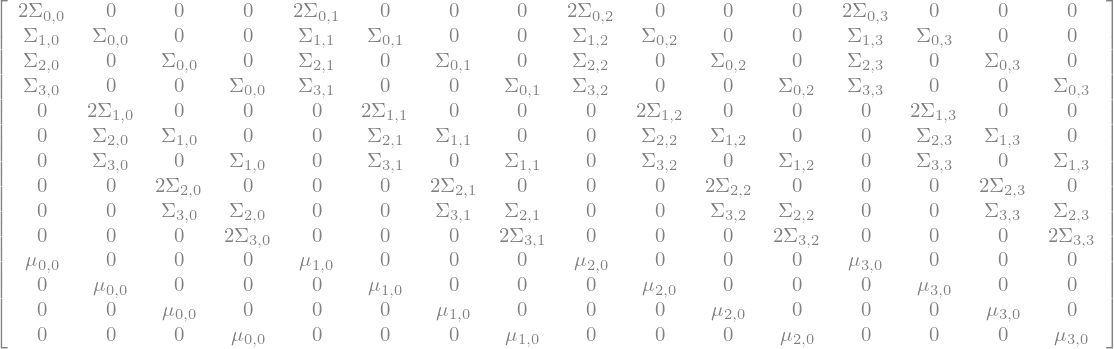

In [11]:
p = 4
cov = MatrixSymbol("Sigma", p, p).as_mutable()
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [ ]:
A.rank()

### 5 nodes
$\text{rank}(A) = 4 = p^2$

In [ ]:
p = 5
cov = MatrixSymbol("Sigma", p, p).as_mutable()
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [ ]:
A.rank()

### 6 nodes
$\text{rank}(A) = 4 = p^2$

In [ ]:
p = 6
cov = MatrixSymbol("Sigma", p, p).as_mutable()
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [ ]:
A.rank()